# SSD7 Training Tutorial

This tutorial explains how to train an SSD7 on the Udacity road traffic datasets, and just generally how to use this SSD implementation.

Disclaimer about SSD7:
As you will see below, training SSD7 on the aforementioned datasets yields alright results, but I'd like to emphasize that SSD7 is not a carefully optimized network architecture. The idea was just to build a low-complexity network that is fast (roughly 127 FPS or more than 3 times as fast as SSD300 on a GTX 1070) for testing purposes. Would slightly different anchor box scaling factors or a slightly different number of filters in individual convolution layers make SSD7 significantly better at similar complexity? I don't know, I haven't tried.

In [1]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

## pruning imports
import tensorflow_model_optimization as tfmot  #Adding pruning imports

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
##

%matplotlib inline

Using TensorFlow backend.


In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

In [3]:
'''
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
'''

"\n# 1: Build the Keras model\n\nK.clear_session() # Clear previous models from memory.\n\nmodel = build_model(image_size=(img_height, img_width, img_channels),\n                    n_classes=n_classes,\n                    mode='training',\n                    l2_regularization=0.0005,\n                    scales=scales,\n                    aspect_ratios_global=aspect_ratios,\n                    aspect_ratios_per_layer=None,\n                    two_boxes_for_ar1=two_boxes_for_ar1,\n                    steps=steps,\n                    offsets=offsets,\n                    clip_boxes=clip_boxes,\n                    variances=variances,\n                    normalize_coords=normalize_coords,\n                    subtract_mean=intensity_mean,\n                    divide_by_stddev=intensity_range)\n\n# 2: Optional: Load some weights\n\n#model.load_weights('./ssd7_weights.h5', by_name=True)\n\n# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model\n\nadam = 

### 2.1 Load the model 

In [4]:
#'''
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'weights.01-3.41.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})
#'''


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
printing neg_pos_ratio Tensor("Const:0", shape=(), dtype=int32)
printing n_neg_min Tensor("Const_1:0", shape=(), dtype=int32)
printing alpha Tensor("Const_2:0", shape=(), dtype=float32)

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
printing neg_pos_ratio -->  Tensor("Const:0", shape=(), dtype=int32)
printing n_positive -->  Tensor("loss/predictions_loss/Sum_2:0", shape=(), dtype=float32)
printing n_neg_min -->  Tensor("Const_1:0", shape=(), dtype=int32)
printing n_neg_losses -->  Tensor("loss/predictions_loss/count_nonzero/Cast_1:0", shape=(

In [5]:
#K.clear_session()

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 480, 3) 0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 480, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 480, 3)  0           input_mean_normalization[0][0]   
______________________________________________________________________________________________

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = '../../ssd_pruning/udacity_driving_datasets/'

# Ground truth
train_labels_filename = '../../ssd_pruning/udacity_driving_datasets/labels_train_car.csv'
val_labels_filename   = '../../ssd_pruning/udacity_driving_datasets/labels_val_car.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)
#
#val_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [8]:
# 3: Set the batch size.

batch_size = 8

# 4: Define the image processing chain.

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)



'''
train_generator = train_dataset.generate(batch_size=batch_size)

val_generator = val_dataset.generate(batch_size=batch_size)

'''

print("Done")

Done


### Setting Callbacks for pruning

In [9]:

#logdir = tempfile.mkdtemp()

import tensorflow as tf


logdir='pruning_summaries/'

filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=False, save_weights_only=True)

callbacks_pruning = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  checkpoint
]




### Introducing Pruning

In [10]:

# Helper function uses `prune_low_magnitude` to make only the 
# Dense layers train with pruning.
import tensorflow as tf

from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched

def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer,pruning_schedule=pruning_sched.ConstantSparsity(0.5, 0))
  return layer




# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)


'''
# Defining pruning parameters

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

'''

####model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model_for_pruning, **pruning_params)

model_for_pruning.compile(optimizer=adam, loss=ssd_loss.compute_loss)
#model_for_pruning.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

model_for_pruning.summary()



printing neg_pos_ratio Tensor("Const:0", shape=(), dtype=int32)
printing n_neg_min Tensor("Const_1:0", shape=(), dtype=int32)
printing alpha Tensor("Const_2:0", shape=(), dtype=float32)
printing neg_pos_ratio -->  Tensor("Const:0", shape=(), dtype=int32)
printing n_positive -->  Tensor("loss_1/predictions_loss/Sum_2:0", shape=(), dtype=float32)
printing n_neg_min -->  Tensor("Const_1:0", shape=(), dtype=int32)
printing n_neg_losses -->  Tensor("loss_1/predictions_loss/count_nonzero/Cast_1:0", shape=(), dtype=int32)
n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.to_int32(n_positive), self.n_neg_min), n_neg_losses)
printing n_negative_keep -->  Tensor("loss_1/predictions_loss/Minimum:0", shape=(), dtype=int32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 480, 3)

### Pruning Alternatives

In [ ]:
#model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model)

#model_for_pruning.summary()


In [ ]:
'''
epochs = 2
num_images = 18000
end_step = np.ceil(num_images / 8).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
'''

In [11]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.

import tensorflow as tf
'''
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
'''

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)
'''
callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]
'''


#logdir = tempfile.mkdtemp()

logdir='pruning_summaries/'

filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min', save_best_only=False, save_weights_only=False)

callbacks_pruning = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  checkpoint,
  csv_logger,
  early_stopping,
  reduce_learning_rate
]
print("Done")

Done


In [ ]:
'''
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 1000


history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=1000,
                    validation_data=val_generator,
                    epochs=final_epoch,                      
                    validation_steps=ceil(val_dataset_size/batch_size),
                    callbacks=callbacks_pruning,
                    initial_epoch=initial_epoch)

'''


In [ ]:
'''
#commenting to load the model with weights

# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 2
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks_pruning,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)
'''

Let's look at how the training and validation loss evolved to check whether our training is going in the right direction:

In [13]:
#'''
initial_epoch   = 0
final_epoch     = 2
steps_per_epoch = 1000

print(model_for_pruning.optimizer)

history = model_for_pruning.fit_generator(generator=train_generator,
                    steps_per_epoch=1000,
                    validation_data=val_generator,
                    epochs=final_epoch,                      
                    validation_steps=ceil(val_dataset_size/batch_size),
                    callbacks=callbacks_pruning,
                    initial_epoch=initial_epoch,
                    use_multiprocessing=False)
#'''

Epoch 1/2
 999/1000 [============================>.] - ETA: 0s - loss: 3.1197
Epoch 00001: saving model to weights.01-2.94.h5
1000/1000 [==============================] - 204s 204ms/step - loss: 3.1192 - val_loss: 2.9361
Epoch 2/2
 999/1000 [============================>.] - ETA: 0s - loss: 2.8533
Epoch 00002: saving model to weights.02-2.86.h5
1000/1000 [==============================] - 198s 198ms/step - loss: 2.8531 - val_loss: 2.8634


### Plotting

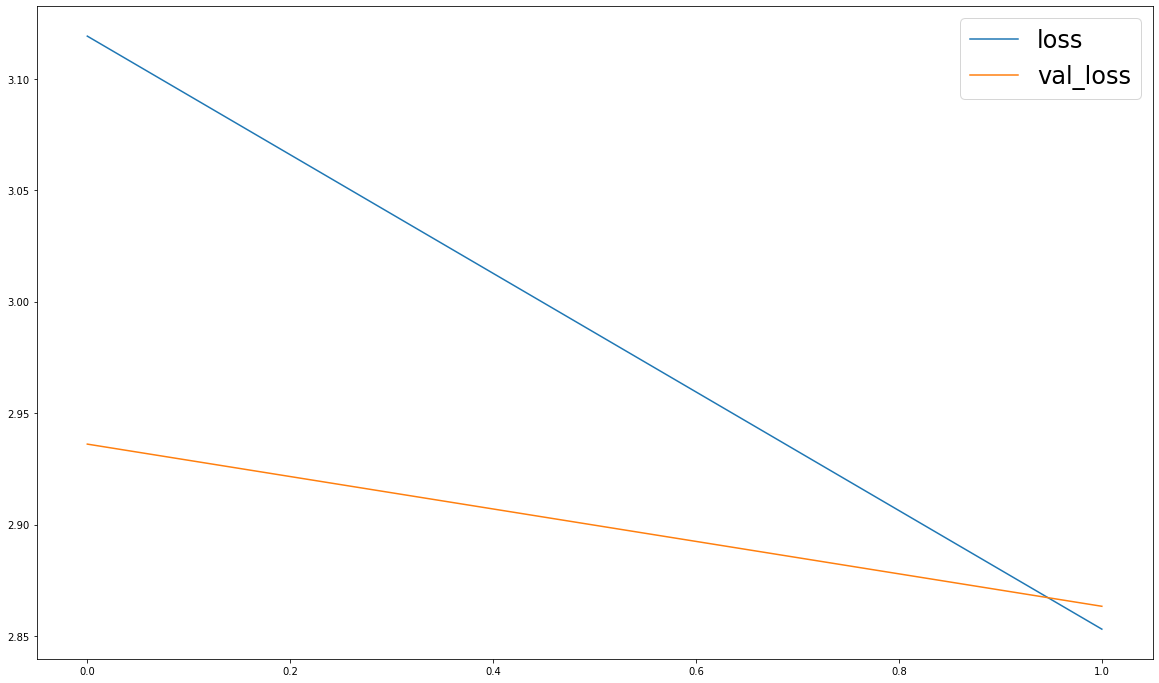

In [14]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

### 5.Make Predictions

In [15]:

# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [16]:
# 2: Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: ../../ssd_pruning/udacity_driving_datasets/1478900336108591037.jpg

Ground truth boxes:

[[  1  28 161  58 185]
 [  1 395 157 451 176]]


In [17]:
# 3: Make a prediction

y_pred = model_for_pruning.predict(batch_images)

In [18]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.68  24.45 158.79  59.59 193.86]]


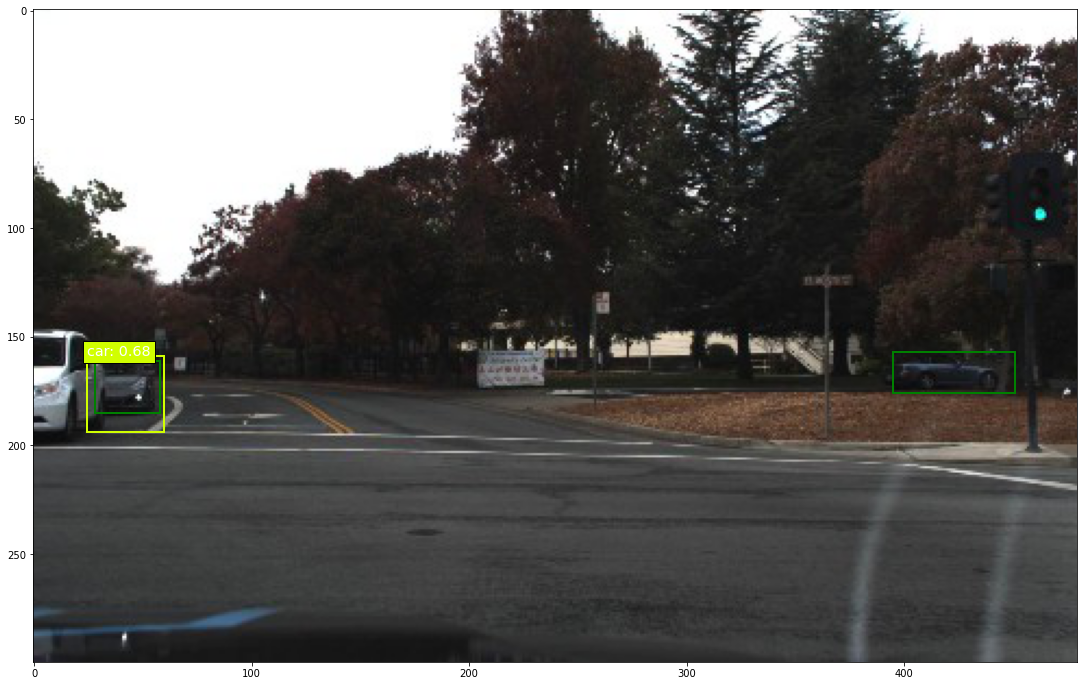

In [19]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})